In [4]:
from __future__ import print_function
import tensorflow as tf
import numpy as np


class MultiHeadAttention(tf.keras.layers.Layer):
    """ Attention Layer - multi-head scaled dot product attention (for encoder and decoder)

        Args:
            num_heads: number of attention heads which will be computed in parallel
            d_model: embedding size of output features

        Call arguments:
            q: query, shape (..., seq_len_q, depth_q)
            k: key, shape == (..., seq_len_k, depth_k)
            v: value, shape == (..., seq_len_v, depth_v)
            mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k) or None.

            Since we use scaled-product attention, we assume seq_len_k = seq_len_v

        Returns:
              attention outputs of shape (batch_size, seq_len_q, d_model)
    """

    def __init__(self, n_heads, d_model, **kwargs):
        super().__init__(**kwargs)
        self.n_heads = n_heads
        self.d_model = d_model
        self.head_depth = self.d_model // self.n_heads

        if self.d_model % self.n_heads != 0:
            raise ValueError("number of heads must divide d_model")

        # define weight matrices
        self.wq = tf.keras.layers.Dense(self.d_model, use_bias=False)  # (d_q, d_model)
        self.wk = tf.keras.layers.Dense(self.d_model, use_bias=False)  # (d_k, d_model)
        self.wv = tf.keras.layers.Dense(self.d_model, use_bias=False)  # (d_v, d_model)

        self.w_out = tf.keras.layers.Dense(self.d_model, use_bias=False)  # (d_model, d_model)

    def split_heads(self, tensor, batch_size):
        """Function for computing attention on several heads simultaneously
        Splits last dimension of a tensor into (num_heads, head_depth).
        Then we transpose it as (batch_size, num_heads, ..., head_depth) so that we can use broadcast
        """
        tensor = tf.reshape(tensor, (batch_size, -1, self.n_heads, self.head_depth))
        return tf.transpose(tensor, perm=[0, 2, 1, 3])

    # treats first parameter q as input, and  k, v as parameters, so input_shape=q.shape
    def call(self, q, k, v, mask=None):
        # shape of q: (batch_size, seq_len_q, d_q)
        batch_size = tf.shape(q)[0]

        # compute Q = q * w_q, ...
        Q = self.wq(q)  # (batch_size, seq_len_q, d_q) x (d_q, d_model) --> (batch_size, seq_len_q, d_model)
        K = self.wk(k)  # ... --> (batch_size, seq_len_k, d_model)
        V = self.wv(v)  # ... --> (batch_size, seq_len_v, d_model)

        # split heads: d_model = num_heads * head_depth + reshape
        Q = self.split_heads(Q, batch_size)  # (batch_size, num_heads, seq_len_q, head_depth)
        K = self.split_heads(K, batch_size)  # (batch_size, num_heads, seq_len_k, head_depth)
        V = self.split_heads(V, batch_size)  # (batch_size, num_heads, seq_len_v, head_depth)

        # similarity between context vector Q and key K // self-similarity in case of self-attention
        compatibility = tf.matmul(Q, K, transpose_b=True)  # (batch_size, num_heads, seq_len_q, seq_len_k)
                                                           # seq_len_q = n_nodes for encoder self-attention
                                                           # seq_len_q = 1 for decoder context-vector attention
                                                           # seq_len_k = n_nodes for both encoder & decoder
        # rescaling
        dk = tf.cast(tf.shape(K)[-1], tf.float32)
        compatibility = compatibility / tf.math.sqrt(dk)

        if mask is not None:
            # we need to reshape mask:
            # (batch_size, seq_len_q, seq_len_k) --> (batch_size, 1, seq_len_q, seq_len_k)
            # so that we will be able to do a broadcast:
            # (batch_size, num_heads, seq_len_q, seq_len_k) + (batch_size, 1, seq_len_q, seq_len_k)
            mask = mask[:, tf.newaxis, :, :]

            # we use tf.where since 0*-np.inf returns nan, but not -np.inf
            # compatibility = tf.where(
            #                     tf.broadcast_to(mask, compatibility.shape), tf.ones_like(compatibility) * (-np.inf),
            #                     compatibility
            #                      )

            compatibility = tf.where(mask,
                                    tf.ones_like(compatibility) * (-np.inf),
                                    compatibility)

        compatibility = tf.nn.softmax(compatibility, axis=-1)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        # Replace NaN by zeros (tf.nn.softmax returns NaNs for masked rows)
        compatibility = tf.where(tf.math.is_nan(compatibility), tf.zeros_like(compatibility), compatibility)

        # seq_len_k = seq_len_v
        attention = tf.matmul(compatibility, V)  # (batch_size, num_heads, seq_len_q, head_depth)

        # transpose back to (batch_size, seq_len_q, num_heads, head_depth)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])

        # concatenate heads (last 2 dimensions)
        attention = tf.reshape(attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # project output to the same dimension
        # this is equiv. to sum in the article (project heads with W_o and sum), beacuse of block-matrix multiplication
        #e.g. https://math.stackexchange.com/questions/2961550/matrix-block-multiplication-definition-properties-and-applications

        output = self.w_out(attention)  # (batch_size, seq_len_q, d_model)

        return output

In [5]:
import tensorflow as tf
#from layers import MultiHeadAttention


class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    """Feed-Forward Sublayer: fully-connected Feed-Forward network,
    built based on MHA vectors from MultiHeadAttention layer with skip-connections

        Args:
            num_heads: number of attention heads in MHA layers.
            input_dim: embedding size that will be used as d_model in MHA layers.
            feed_forward_hidden: number of neuron units in each FF layer.

        Call arguments:
            x: batch of shape (batch_size, n_nodes, node_embedding_size).
            mask: mask for MHA layer

        Returns:
               outputs of shape (batch_size, n_nodes, input_dim)

    """

    def __init__(self, input_dim, num_heads, feed_forward_hidden=512, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(n_heads=num_heads, d_model=input_dim, name='MHA')
        self.ff1 = tf.keras.layers.Dense(feed_forward_hidden, name='ff1')
        self.ff2 = tf.keras.layers.Dense(input_dim, name='ff2')

    def call(self, x, mask=None):
        mha_out = self.mha(x, x, x, mask)
        sc1_out = tf.keras.layers.Add()([x, mha_out])
        tanh1_out = tf.keras.activations.tanh(sc1_out)

        ff1_out = self.ff1(tanh1_out)
        relu1_out = tf.keras.activations.relu(ff1_out)
        ff2_out = self.ff2(relu1_out)
        sc2_out = tf.keras.layers.Add()([tanh1_out, ff2_out])
        tanh2_out = tf.keras.activations.tanh(sc2_out)

        return tanh2_out

class GraphAttentionEncoder(tf.keras.layers.Layer):
    """Graph Encoder, which uses MultiHeadAttentionLayer sublayer.

        Args:
            input_dim: embedding size that will be used as d_model in MHA layers.
            num_heads: number of attention heads in MHA layers.
            num_layers: number of attention layers that will be used in encoder.
            feed_forward_hidden: number of neuron units in each FF layer.

        Call arguments:
            x: tuples of 3 tensors:  (batch_size, 2), (batch_size, n_nodes-1, 2), (batch_size, n_nodes-1)
            First tensor contains coordinates for depot, second one is for coordinates of other nodes,
            Last tensor is for normalized demands for nodes except depot

            mask: mask for MHA layer

        Returns:
               Embedding for all nodes + mean embedding for graph.
               Tuples ((batch_size, n_nodes, input_dim), (batch_size, input_dim))
    """

    def __init__(self, input_dim, num_heads, num_layers, feed_forward_hidden=512):
        super().__init__()

        self.input_dim = input_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.feed_forward_hidden = feed_forward_hidden

        # initial embeddings (batch_size, n_nodes-1, 2) --> (batch-size, input_dim), separate for depot and other nodes
        self.init_embed_depot = tf.keras.layers.Dense(self.input_dim, name='init_embed_depot')  # nn.Linear(2, embedding_dim)
        self.init_embed = tf.keras.layers.Dense(self.input_dim, name='init_embed')

        self.mha_layers = [MultiHeadAttentionLayer(self.input_dim, self.num_heads, self.feed_forward_hidden)
                            for _ in range(self.num_layers)]

    def call(self, x, mask=None, cur_num_nodes=None):

        x = tf.concat((self.init_embed_depot(x[0])[:, None, :],  # (batch_size, 2) --> (batch_size, 1, 2)
                       self.init_embed(tf.concat((x[1], x[2][:, :, None]), axis=-1))  # (batch_size, n_nodes-1, 2) + (batch_size, n_nodes-1)
                       ), axis=1)  # (batch_size, n_nodes, input_dim)

        # stack attention layers
        for i in range(self.num_layers):
            x = self.mha_layers[i](x, mask)

        if mask is not None:
            output = (x, tf.reduce_sum(x, axis=1) / cur_num_nodes)
        else:
            output = (x, tf.reduce_mean(x, axis=1))
            
        return output # (embeds of nodes, avg graph embed)=((batch_size, n_nodes, input), (batch_size, input_dim))


In [6]:
import tensorflow as tf

class AgentVRP():

    VEHICLE_CAPACITY = 1.0

    def __init__(self, input):

        depot = input[0]
        loc = input[1]

        self.batch_size, self.n_loc, _ = loc.shape  # (batch_size, n_nodes, 2)

        # Coordinates of depot + other nodes
        self.coords = tf.concat((depot[:, None, :], loc), -2)
        self.demand = tf.cast(input[2], tf.float32)

        # Indices of graphs in batch
        self.ids = tf.range(self.batch_size, dtype=tf.int64)[:, None]

        # State
        self.prev_a = tf.zeros((self.batch_size, 1), dtype=tf.float32)
        self.from_depot = self.prev_a == 0
        self.used_capacity = tf.zeros((self.batch_size, 1), dtype=tf.float32)

        # Nodes that have been visited will be marked with 1
        self.visited = tf.zeros((self.batch_size, 1, self.n_loc + 1), dtype=tf.uint8)

        # Step counter
        self.i = tf.zeros(1, dtype=tf.int64)

        # Constant tensors for scatter update (in step method)
        self.step_updates = tf.ones((self.batch_size, 1), dtype=tf.uint8)  # (batch_size, 1)
        self.scatter_zeros = tf.zeros((self.batch_size, 1), dtype=tf.int64)  # (batch_size, 1)

    @staticmethod
    def outer_pr(a, b):
        """Outer product of matrices
        """
        return tf.einsum('ki,kj->kij', a, b)

    def get_att_mask(self):
        """ Mask (batch_size, n_nodes, n_nodes) for attention encoder.
            We mask already visited nodes except depot
        """

        # We dont want to mask depot
        att_mask = tf.squeeze(tf.cast(self.visited, tf.float32), axis=-2)[:, 1:]  # [batch_size, 1, n_nodes] --> [batch_size, n_nodes-1]
        
        # Number of nodes in new instance after masking
        cur_num_nodes = self.n_loc + 1 - tf.reshape(tf.reduce_sum(att_mask, -1), (-1,1))  # [batch_size, 1]
        
        att_mask = tf.concat((tf.zeros(shape=(att_mask.shape[0],1),dtype=tf.float32),att_mask), axis=-1)

        ones_mask = tf.ones_like(att_mask)

        # Create square attention mask from row-like mask
        att_mask = AgentVRP.outer_pr(att_mask, ones_mask) \
                            + AgentVRP.outer_pr(ones_mask, att_mask)\
                            - AgentVRP.outer_pr(att_mask, att_mask)
        
        return tf.cast(att_mask, dtype=tf.bool), cur_num_nodes

    def all_finished(self):
        """Checks if all games are finished
        """
        return tf.reduce_all(tf.cast(self.visited, tf.bool))

    def partial_finished(self):
        """Checks if partial solution for all graphs has been built, i.e. all agents came back to depot
        """
        return tf.reduce_all(self.from_depot) and self.i != 0

    def get_mask(self):
        """ Returns a mask (batch_size, 1, n_nodes) with available actions.
            Impossible nodes are masked.
        """

        # Exclude depot
        visited_loc = self.visited[:, :, 1:]

        # Mark nodes which exceed vehicle capacity
        exceeds_cap = self.demand + self.used_capacity > self.VEHICLE_CAPACITY

        # We mask nodes that are already visited or have too much demand
        # Also for dynamical model we stop agent at depot when it arrives there (for partial solution)
        mask_loc = tf.cast(visited_loc, tf.bool) | exceeds_cap[:, None, :] | ((self.i > 0) & self.from_depot[:, None, :])

        # We can choose depot if 1) we are not in depot OR 2) all nodes are visited
        mask_depot = self.from_depot & (tf.reduce_sum(tf.cast(mask_loc == False, tf.int32), axis=-1) > 0)

        return tf.concat([mask_depot[:, :, None], mask_loc], axis=-1)

    def step(self, action):

        # Update current state
        selected = action[:, None]

        self.prev_a = selected
        self.from_depot = self.prev_a == 0

        # We have to shift indices by 1 since demand doesn't include depot
        # 0-index in demand corresponds to the FIRST node
        selected_demand = tf.gather_nd(self.demand,
                                       tf.concat([self.ids, tf.clip_by_value(self.prev_a - 1, 0, self.n_loc - 1)], axis=1)
                                       )[:, None]  # (batch_size, 1)

        # We add current node capacity to used capacity and set it to zero if we return to the depot
        self.used_capacity = (self.used_capacity + selected_demand) * (1.0 - tf.cast(self.from_depot, tf.float32))

        # Update visited nodes (set 1 to visited nodes)
        idx = tf.cast(tf.concat((self.ids, self.scatter_zeros, self.prev_a), axis=-1), tf.int32)[:, None, :]  # (batch_size, 1, 3)
        self.visited = tf.tensor_scatter_nd_update(self.visited, idx, self.step_updates)  # (batch_size, 1, n_nodes)

        self.i = self.i + 1

    @staticmethod
    def get_costs(dataset, pi):

        # Place nodes with coordinates in order of decoder tour
        loc_with_depot = tf.concat([dataset[0][:, None, :], dataset[1]], axis=1)  # (batch_size, n_nodes, 2)
        d = tf.gather(loc_with_depot, tf.cast(pi, tf.int32), batch_dims=1)

        # Calculation of total distance
        # Note: first element of pi is not depot, but the first selected node in the path
        return (tf.reduce_sum(tf.norm(d[:, 1:] - d[:, :-1], ord=2, axis=2), axis=1)
                + tf.norm(d[:, 0] - dataset[0], ord=2, axis=1) # Distance from depot to first selected node
                + tf.norm(d[:, -1] - dataset[0], ord=2, axis=1))  # Distance from last selected node (!=0 for graph with longest path) to depot


In [7]:
import tensorflow as tf
import numpy as np

#from attention_graph_encoder import GraphAttentionEncoder
#from enviroment import AgentVRP


def set_decode_type(model, decode_type):
    model.set_decode_type(decode_type)

class AttentionDynamicModel(tf.keras.Model):

    def __init__(self,
                 embedding_dim,
                 n_encode_layers=2,
                 n_heads=8,
                 tanh_clipping=10.
                 ):

        super().__init__()

        # attributes for MHA
        self.embedding_dim = embedding_dim
        self.n_encode_layers = n_encode_layers
        self.decode_type = None

        # attributes for VRP problem
        self.problem = AgentVRP
        self.n_heads = n_heads

        # Encoder part
        self.embedder = GraphAttentionEncoder(input_dim=self.embedding_dim,
                                              num_heads=self.n_heads,
                                              num_layers=self.n_encode_layers
                                              )

        # Decoder part

        self.output_dim = self.embedding_dim
        self.num_heads = n_heads

        self.head_depth = self.output_dim // self.num_heads
        self.dk_mha_decoder = tf.cast(self.head_depth, tf.float32)  # for decoding in mha_decoder
        self.dk_get_loc_p = tf.cast(self.output_dim, tf.float32)  # for decoding in mha_decoder

        if self.output_dim % self.num_heads != 0:
            raise ValueError("number of heads must divide d_model=output_dim")

        self.tanh_clipping = tanh_clipping

        # we split projection matrix Wq into 2 matrices: Wq*[h_c, h_N, D] = Wq_context*h_c + Wq_step_context[h_N, D]
        self.wq_context = tf.keras.layers.Dense(self.output_dim, use_bias=False,
                                                name='wq_context')  # (d_q_context, output_dim)
        self.wq_step_context = tf.keras.layers.Dense(self.output_dim, use_bias=False,
                                                     name='wq_step_context')  # (d_q_step_context, output_dim)

        # we need two Wk projections since there is MHA followed by 1-head attention - they have different keys K
        self.wk = tf.keras.layers.Dense(self.output_dim, use_bias=False, name='wk')  # (d_k, output_dim)
        self.wk_tanh = tf.keras.layers.Dense(self.output_dim, use_bias=False, name='wk_tanh')  # (d_k_tanh, output_dim)

        # we dont need Wv projection for 1-head attention: only need attention weights as outputs
        self.wv = tf.keras.layers.Dense(self.output_dim, use_bias=False, name='wv')  # (d_v, output_dim)

        # we dont need wq for 1-head tanh attention, since we can absorb it into w_out
        self.w_out = tf.keras.layers.Dense(self.output_dim, use_bias=False, name='w_out')  # (d_model, d_model)

    def set_decode_type(self, decode_type):
        self.decode_type = decode_type

    def split_heads(self, tensor, batch_size):
        """Function for computing attention on several heads simultaneously
        Splits last dimension of a tensor into (num_heads, head_depth).
        Then we transpose it as (batch_size, num_heads, ..., head_depth) so that we can use broadcast
        """
        tensor = tf.reshape(tensor, (batch_size, -1, self.num_heads, self.head_depth))
        return tf.transpose(tensor, perm=[0, 2, 1, 3])

    def _select_node(self, logits):
        """Select next node based on decoding type.
        """

        # assert tf.reduce_all(logits == logits), "Probs should not contain any nans"

        if self.decode_type == "greedy":
            selected = tf.math.argmax(logits, axis=-1)  # (batch_size, 1)

        elif self.decode_type == "sampling":
            # logits has a shape of (batch_size, 1, n_nodes), we have to squeeze it
            # to (batch_size, n_nodes) since tf.random.categorical requires matrix
            selected = tf.random.categorical(logits[:, 0, :], 1)  # (bach_size,1)
        else:
            assert False, "Unknown decode type"

        return tf.squeeze(selected, axis=-1)  # (bach_size,)

    def get_step_context(self, state, embeddings):
        """Takes a state and graph embeddings,
           Returns a part [h_N, D] of context vector [h_c, h_N, D],
           that is related to RL Agent last step.
        """
        # index of previous node
        prev_node = state.prev_a  # (batch_size, 1)

        # from embeddings=(batch_size, n_nodes, input_dim) select embeddings of previous nodes
        cur_embedded_node = tf.gather(embeddings, tf.cast(prev_node, tf.int32), batch_dims=1)  # (batch_size, 1, input_dim)

        # add remaining capacity
        step_context = tf.concat([cur_embedded_node, self.problem.VEHICLE_CAPACITY - state.used_capacity[:, :, None]], axis=-1)

        return step_context  # (batch_size, 1, input_dim + 1)

    def decoder_mha(self, Q, K, V, mask=None):
        """ Computes Multi-Head Attention part of decoder
        Basically, its a part of MHA sublayer, but we cant construct a layer since Q changes in a decoding loop.

        Args:
            mask: a mask for visited nodes,
                has shape (batch_size, seq_len_q, seq_len_k), seq_len_q = 1 for context vector attention in decoder
            Q: query (context vector for decoder)
                    has shape (..., seq_len_q, head_depth) with seq_len_q = 1 for context_vector attention in decoder
            K, V: key, value (projections of nodes embeddings)
                have shape (..., seq_len_k, head_depth), (..., seq_len_v, head_depth),
                                                                with seq_len_k = seq_len_v = n_nodes for decoder
        """

        compatibility = tf.matmul(Q, K, transpose_b=True)/tf.math.sqrt(self.dk_mha_decoder)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        if mask is not None:

            # we need to reshape mask:
            # (batch_size, seq_len_q, seq_len_k) --> (batch_size, 1, seq_len_q, seq_len_k)
            # so that we will be able to do a broadcast:
            # (batch_size, num_heads, seq_len_q, seq_len_k) + (batch_size, 1, seq_len_q, seq_len_k)
            mask = mask[:, tf.newaxis, :, :]

            # we use tf.where since 0*-np.inf returns nan, but not -np.inf
            # compatibility = tf.where(
            #                     tf.broadcast_to(mask, compatibility.shape), tf.ones_like(compatibility) * (-np.inf),
            #                     compatibility
            #                      )

            compatibility = tf.where(mask,
                                     tf.ones_like(compatibility) * (-np.inf),
                                     compatibility
                                     )


        compatibility = tf.nn.softmax(compatibility, axis=-1)  # (batch_size, num_heads, seq_len_q, seq_len_k)
        attention = tf.matmul(compatibility, V)  # (batch_size, num_heads, seq_len_q, head_depth)

        # transpose back to (batch_size, seq_len_q, num_heads, depth)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])

        # concatenate heads (last 2 dimensions)
        attention = tf.reshape(attention, (self.batch_size, -1, self.output_dim))  # (batch_size, seq_len_q, output_dim)

        output = self.w_out(attention)  # (batch_size, seq_len_q, output_dim), seq_len_q = 1 for context att in decoder

        return output

    def get_log_p(self, Q, K, mask=None):
        """Single-Head attention sublayer in decoder,
        computes log-probabilities for node selection.

        Args:
            mask: mask for nodes
            Q: query (output of mha layer)
                    has shape (batch_size, seq_len_q, output_dim), seq_len_q = 1 for context attention in decoder
            K: key (projection of node embeddings)
                    has shape  (batch_size, seq_len_k, output_dim), seq_len_k = n_nodes for decoder
        """

        compatibility = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(self.dk_get_loc_p)
        compatibility = tf.math.tanh(compatibility) * self.tanh_clipping

        if mask is not None:

            # we dont need to reshape mask like we did in multi-head version:
            # (batch_size, seq_len_q, seq_len_k) --> (batch_size, num_heads, seq_len_q, seq_len_k)
            # since we dont have multiple heads

            # compatibility = tf.where(
            #                     tf.broadcast_to(mask, compatibility.shape), tf.ones_like(compatibility) * (-np.inf),
            #                     compatibility
            #                      )

            compatibility = tf.where(mask,
                                     tf.ones_like(compatibility) * (-np.inf),
                                     compatibility
                                     )

        log_p = tf.nn.log_softmax(compatibility, axis=-1)  # (batch_size, seq_len_q, seq_len_k)

        return log_p

    def get_log_likelihood(self, _log_p, a):

        # Get log_p corresponding to selected actions
        log_p = tf.gather_nd(_log_p, tf.cast(tf.expand_dims(a, axis=-1), tf.int32), batch_dims=2)

        # Calculate log_likelihood
        return tf.reduce_sum(log_p,1)

    def get_projections(self, embeddings, context_vectors):

        # we compute some projections (common for each policy step) before decoding loop for efficiency
        K = self.wk(embeddings)  # (batch_size, n_nodes, output_dim)
        K_tanh = self.wk_tanh(embeddings)  # (batch_size, n_nodes, output_dim)
        V = self.wv(embeddings)  # (batch_size, n_nodes, output_dim)
        Q_context = self.wq_context(context_vectors[:, tf.newaxis, :])  # (batch_size, 1, output_dim)

        # we dont need to split K_tanh since there is only 1 head; Q will be split in decoding loop
        K = self.split_heads(K, self.batch_size)  # (batch_size, num_heads, n_nodes, head_depth)
        V = self.split_heads(V, self.batch_size)  # (batch_size, num_heads, n_nodes, head_depth)

        return K_tanh, Q_context, K, V

    def call(self, inputs, return_pi=False):

        embeddings, mean_graph_emb = self.embedder(inputs)

        self.batch_size = tf.shape(embeddings)[0]

        outputs = []
        sequences = []

        state = self.problem(inputs)

        K_tanh, Q_context, K, V = self.get_projections(embeddings, mean_graph_emb)

        # Perform decoding steps
        i = 0
        inner_i = 0

        while not state.all_finished():

            if i > 0:
                state.i = tf.zeros(1, dtype=tf.int64)
                att_mask, cur_num_nodes = state.get_att_mask()
                embeddings, context_vectors = self.embedder(inputs, att_mask, cur_num_nodes)
                K_tanh, Q_context, K, V = self.get_projections(embeddings, context_vectors)

            inner_i = 0
            while not state.partial_finished():

                step_context = self.get_step_context(state, embeddings)  # (batch_size, 1), (batch_size, 1, input_dim + 1)
                Q_step_context = self.wq_step_context(step_context)  # (batch_size, 1, output_dim)
                Q = Q_context + Q_step_context

                # split heads for Q
                Q = self.split_heads(Q, self.batch_size)  # (batch_size, num_heads, 1, head_depth)

                # get current mask
                mask = state.get_mask()  # (batch_size, 1, n_nodes) with True/False indicating where agent can go

                # compute MHA decoder vectors for current mask
                mha = self.decoder_mha(Q, K, V, mask)  # (batch_size, 1, output_dim)

                # compute probabilities
                log_p = self.get_log_p(mha, K_tanh, mask)  # (batch_size, 1, n_nodes)

                # next step is to select node
                selected = self._select_node(log_p)

                state.step(selected)

                outputs.append(log_p[:, 0, :])
                sequences.append(selected)

                inner_i += 1

            i += 1

        _log_p, pi = tf.stack(outputs, 1), tf.cast(tf.stack(sequences, 1), tf.float32)

        cost = self.problem.get_costs(inputs, pi)

        ll = self.get_log_likelihood(_log_p, pi)

        if return_pi:
            return cost, ll, pi

        return cost, ll


In [9]:
import pickle
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from datetime import datetime
import time


def create_data_on_disk(graph_size, num_samples, is_save=True, filename=None, is_return=False, seed=1234):
    """Generate validation dataset (with SEED) and save
    """

    CAPACITIES = {
        10: 20.,
        20: 30.,
        50: 40.,
        100: 50.
    }
    depo, graphs, demand = (tf.random.uniform(minval=0, maxval=1, shape=(num_samples, 2), seed=seed),
                            tf.random.uniform(minval=0, maxval=1, shape=(num_samples, graph_size, 2), seed=seed),
                            tf.cast(tf.random.uniform(minval=1, maxval=10, shape=(num_samples, graph_size),
                                                      dtype=tf.int32, seed=seed), tf.float32) / tf.cast(CAPACITIES[graph_size], tf.float32)
                            )
    if is_save:
        save_to_pickle('Validation_dataset_{}.pkl'.format(filename), (depo, graphs, demand))

    if is_return:
        return tf.data.Dataset.from_tensor_slices((list(depo), list(graphs), list(demand)))


def save_to_pickle(filename, item):
    """Save to pickle
    """
    with open(filename, 'wb') as handle:
        pickle.dump(item, handle, protocol=pickle.HIGHEST_PROTOCOL)


def read_from_pickle(path, return_tf_data_set=True, num_samples=None):
    """Read dataset from file (pickle)
    """

    objects = []
    with (open(path, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    objects = objects[0]
    if return_tf_data_set:
        depo, graphs, demand = objects
        if num_samples is not None:
            return tf.data.Dataset.from_tensor_slices((list(depo), list(graphs), list(demand))).take(num_samples)
        else:
            return tf.data.Dataset.from_tensor_slices((list(depo), list(graphs), list(demand)))
    else:
        return objects


def generate_data_onfly(num_samples=10000, graph_size=20):
    """Generate temp dataset in memory
    """

    CAPACITIES = {
        10: 20.,
        20: 30.,
        50: 40.,
        100: 50.
    }
    depo, graphs, demand = (tf.random.uniform(minval=0, maxval=1, shape=(num_samples, 2)),
                            tf.random.uniform(minval=0, maxval=1, shape=(num_samples, graph_size, 2)),
                            tf.cast(tf.random.uniform(minval=1, maxval=10, shape=(num_samples, graph_size),
                                                      dtype=tf.int32), tf.float32)/tf.cast(CAPACITIES[graph_size], tf.float32)
                            )

    return tf.data.Dataset.from_tensor_slices((list(depo), list(graphs), list(demand)))


def get_results(train_loss_results, train_cost_results, val_cost, save_results=True, filename=None, plots=True):

    epochs_num = len(train_loss_results)

    df_train = pd.DataFrame(data={'epochs': list(range(epochs_num)),
                                  'loss': train_loss_results,
                                  'cost': train_cost_results,
                                  })
    df_test = pd.DataFrame(data={'epochs': list(range(epochs_num)),
                                 'val_сost': val_cost})
    if save_results:
        df_train.to_excel('train_results_{}.xlsx'.format(filename), index=False)
        df_test.to_excel('test_results_{}.xlsx'.format(filename), index=False)

    if plots:
        plt.figure(figsize=(15, 9))
        ax = sns.lineplot(x='epochs', y='loss', data=df_train, color='salmon', label='train loss')
        ax2 = ax.twinx()
        sns.lineplot(x='epochs', y='cost', data=df_train, color='cornflowerblue', label='train cost', ax=ax2)
        sns.lineplot(x='epochs', y='val_сost', data=df_test, palette='darkblue', label='val cost').set(ylabel='cost')
        ax.legend(loc=(0.75, 0.90), ncol=1)
        ax2.legend(loc=(0.75, 0.95), ncol=2)
        ax.grid(axis='x')
        ax2.grid(True)
        plt.savefig('learning_curve_plot_{}.jpg'.format(filename))
        plt.show()


def get_journey(batch, pi, title, ind_in_batch=0):
    """Plots journey of agent

    Args:
        batch: dataset of graphs
        pi: paths of agent obtained from model
        ind_in_batch: index of graph in batch to be plotted
    """

    # Remove extra zeros
    pi_ = get_clean_path(pi[ind_in_batch].numpy())

    # Unpack variables
    depo_coord = batch[0][ind_in_batch].numpy()
    points_coords = batch[1][ind_in_batch].numpy()
    demands = batch[2][ind_in_batch].numpy()
    node_labels = ['(' + str(x[0]) + ', ' + x[1] + ')' for x in enumerate(demands.round(2).astype(str))]

    # Concatenate depot and points
    full_coords = np.concatenate((depo_coord.reshape(1, 2), points_coords))

    # Get list with agent loops in path
    list_of_paths = []
    cur_path = []
    for idx, node in enumerate(pi_):

        cur_path.append(node)

        if idx != 0 and node == 0:
            if cur_path[0] != 0:
                cur_path.insert(0, 0)
            list_of_paths.append(cur_path)
            cur_path = []

    list_of_path_traces = []
    for path_counter, path in enumerate(list_of_paths):
        coords = full_coords[[int(x) for x in path]]

        # Calculate length of each agent loop
        lengths = np.sqrt(np.sum(np.diff(coords, axis=0) ** 2, axis=1))
        total_length = np.sum(lengths)

        list_of_path_traces.append(go.Scatter(x=coords[:, 0],
                                              y=coords[:, 1],
                                              mode="markers+lines",
                                              name=f"path_{path_counter}, length={total_length:.2f}",
                                              opacity=1.0))

    trace_points = go.Scatter(x=points_coords[:, 0],
                              y=points_coords[:, 1],
                              mode='markers+text',
                              name='destinations',
                              text=node_labels,
                              textposition='top center',
                              marker=dict(size=7),
                              opacity=1.0
                              )

    trace_depo = go.Scatter(x=[depo_coord[0]],
                            y=[depo_coord[1]],
                            text=['1.0'], textposition='bottom center',
                            mode='markers+text',
                            marker=dict(size=15),
                            name='depot'
                            )

    layout = go.Layout(title='<b>Example: {}</b>'.format(title),
                       xaxis=dict(title='X coordinate'),
                       yaxis=dict(title='Y coordinate'),
                       showlegend=True,
                       width=1000,
                       height=1000,
                       template="plotly_white"
                       )

    data = [trace_points, trace_depo] + list_of_path_traces
    print('Current path: ', pi_)
    fig = go.Figure(data=data, layout=layout)
    fig.show()

def get_cur_time():
    """Returns local time as string
    """
    ts = time.time()
    return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')


def get_clean_path(arr):
    """Returns extra zeros from path.
       Dynamical model generates duplicated zeros for several graphs when obtaining partial solutions.
    """

    p1, p2 = 0, 1
    output = []

    while p2 < len(arr):

        if arr[p1] != arr[p2]:
            output.append(arr[p1])
            if p2 == len(arr) - 1:
                output.append(arr[p2])

        p1 += 1
        p2 += 1

    if output[0] != 0:
        output.insert(0, 0.0)
    if output[-1] != 0:
        output.append(0.0)

    return output

In [10]:
import tensorflow as tf
from scipy.stats import ttest_rel
from tqdm import tqdm
import numpy as np

# from attention_dynamic_model import AttentionDynamicModel
# from attention_dynamic_model import set_decode_type
# from utils import generate_data_onfly


def copy_of_tf_model(model, embedding_dim=128, graph_size=20):
    """Copy model weights to new model
    """
    # https://stackoverflow.com/questions/56841736/how-to-copy-a-network-in-tensorflow-2-0
    CAPACITIES = {10: 20.,
                  20: 30.,
                  50: 40.,
                  100: 50.
                  }

    data_random = [tf.random.uniform((2, 2,), minval=0, maxval=1, dtype=tf.dtypes.float32),
                   tf.random.uniform((2, graph_size, 2), minval=0, maxval=1, dtype=tf.dtypes.float32),
                   tf.cast(tf.random.uniform(minval=1, maxval=10, shape=(2, graph_size),
                                             dtype=tf.int32), tf.float32) / tf.cast(CAPACITIES[graph_size], tf.float32)]

    new_model = AttentionDynamicModel(embedding_dim)
    set_decode_type(new_model, "sampling")
    _, _ = new_model(data_random)

    for a, b in zip(new_model.variables, model.variables):
        a.assign(b)

    return new_model

def rollout(model, dataset, batch_size = 1000, disable_tqdm = False):
    # Evaluate model in greedy mode
    set_decode_type(model, "greedy")
    costs_list = []

    for batch in tqdm(dataset.batch(batch_size), disable=disable_tqdm, desc="Rollout greedy execution"):
        cost, _ = model(batch)
        costs_list.append(cost)

    return tf.concat(costs_list, axis=0)


def validate(dataset, model, batch_size=1000):
    """Validates model on given dataset in greedy mode
    """
    val_costs = rollout(model, dataset, batch_size=batch_size)
    set_decode_type(model, "sampling")
    mean_cost = tf.reduce_mean(val_costs)
    print(f"Validation score: {np.round(mean_cost, 4)}")
    return mean_cost


class RolloutBaseline:

    def __init__(self, model, filename,
                 from_checkpoint=False,
                 path_to_checkpoint=None,
                 wp_n_epochs=1,
                 epoch=0,
                 num_samples=10000,
                 warmup_exp_beta=0.8,
                 embedding_dim=128,
                 graph_size=20
                 ):
        """
        Args:
            model: current model
            filename: suffix for baseline checkpoint filename
            from_checkpoint: start from checkpoint flag
            path_to_checkpoint: path to baseline model weights
            wp_n_epochs: number of warm-up epochs
            epoch: current epoch number
            num_samples: number of samples to be generated for baseline dataset
            warmup_exp_beta: warmup mixing parameter (exp. moving average parameter)

        """

        self.num_samples = num_samples
        self.cur_epoch = epoch
        self.wp_n_epochs = wp_n_epochs
        self.beta = warmup_exp_beta

        # controls the amount of warmup
        self.alpha = 0.0

        self.running_average_cost = None

        # Checkpoint params
        self.filename = filename
        self.from_checkpoint = from_checkpoint
        self.path_to_checkpoint = path_to_checkpoint

        # Problem params
        self.embedding_dim = embedding_dim
        self.graph_size = graph_size

        # create and evaluate initial baseline
        self._update_baseline(model, epoch)


    def _update_baseline(self, model, epoch):

        # Load or copy baseline model based on self.from_checkpoint condition
        if self.from_checkpoint and self.alpha == 0:
            print('Baseline model loaded')
            self.model = load_tf_model(self.path_to_checkpoint,
                                       embedding_dim=self.embedding_dim,
                                       graph_size=self.graph_size)
        else:
            self.model = copy_of_tf_model(model,
                                          embedding_dim=self.embedding_dim,
                                          graph_size=self.graph_size)

            # For checkpoint
            self.model.save_weights('baseline_checkpoint_epoch_{}_{}.h5'.format(epoch, self.filename), save_format='h5')

        # We generate a new dataset for baseline model on each baseline update to prevent possible overfitting
        self.dataset = generate_data_onfly(num_samples=self.num_samples, graph_size=self.graph_size)

        print(f"Evaluating baseline model on baseline dataset (epoch = {epoch})")
        self.bl_vals = rollout(self.model, self.dataset)
        self.mean = tf.reduce_mean(self.bl_vals)
        self.cur_epoch = epoch

    def ema_eval(self, cost):
        """This is running average of cost through previous batches (only for warm-up epochs)
        """

        if self.running_average_cost is None:
            self.running_average_cost = tf.reduce_mean(cost)
        else:
            self.running_average_cost = self.beta * self.running_average_cost + (1. - self.beta) * tf.reduce_mean(cost)

        return self.running_average_cost

    def eval(self, batch, cost):
        """Evaluates current baseline model on single training batch
        """

        if self.alpha == 0:
            return self.ema_eval(cost)

        if self.alpha < 1:
            v_ema = self.ema_eval(cost)
        else:
            v_ema = 0.0

        v_b, _ = self.model(batch)

        v_b = tf.stop_gradient(v_b)
        v_ema = tf.stop_gradient(v_ema)

        # Combination of baseline cost and exp. moving average cost
        return self.alpha * v_b + (1 - self.alpha) * v_ema

    def eval_all(self, dataset):
        """Evaluates current baseline model on the whole dataset only for non warm-up epochs
        """

        if self.alpha < 1:
            return None

        val_costs = rollout(self.model, dataset, batch_size=2048)

        return val_costs

    def epoch_callback(self, model, epoch):
        """Compares current baseline model with the training model and updates baseline if it is improved
        """

        self.cur_epoch = epoch

        print(f"Evaluating candidate model on baseline dataset (callback epoch = {self.cur_epoch})")
        candidate_vals = rollout(model, self.dataset)  # costs for training model on baseline dataset
        candidate_mean = tf.reduce_mean(candidate_vals)

        diff = candidate_mean - self.mean

        print(f"Epoch {self.cur_epoch} candidate mean {candidate_mean}, baseline epoch {self.cur_epoch} mean {self.mean}, difference {diff}")

        if diff < 0:
            # statistic + p-value
            t, p = ttest_rel(candidate_vals, self.bl_vals)

            p_val = p / 2
            print(f"p-value: {p_val}")

            if p_val < 0.05:
                print('Update baseline')
                self._update_baseline(model, self.cur_epoch)

        # alpha controls the amount of warmup
        if self.alpha < 1.0:
            self.alpha = (self.cur_epoch + 1) / float(self.wp_n_epochs)
            print(f"alpha was updated to {self.alpha}")


def load_tf_model(path, embedding_dim=128, graph_size=20, n_encode_layers=2):
    """Load model weights from hd5 file
    """
    # https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model
    CAPACITIES = {10: 20.,
                  20: 30.,
                  50: 40.,
                  100: 50.
                  }

    data_random = [tf.random.uniform((2, 2,), minval=0, maxval=1, dtype=tf.dtypes.float32),
                   tf.random.uniform((2, graph_size, 2), minval=0, maxval=1, dtype=tf.dtypes.float32),
                   tf.cast(tf.random.uniform(minval=1, maxval=10, shape=(2, graph_size),
                                             dtype=tf.int32), tf.float32) / tf.cast(CAPACITIES[graph_size], tf.float32)]

    model_loaded = AttentionDynamicModel(embedding_dim,n_encode_layers=n_encode_layers)
    set_decode_type(model_loaded, "greedy")
    _, _ = model_loaded(data_random)

    model_loaded.load_weights(path)

    return model_loaded

In [14]:
from tqdm import tqdm
import pandas as pd
import tensorflow as tf

# from attention_dynamic_model import set_decode_type
# from reinforce_baseline import validate

# from utils import generate_data_onfly, get_results, get_cur_time
from time import gmtime, strftime


def train_model(optimizer,
                model_tf,
                baseline,
                validation_dataset,
                samples = 1280000,
                batch = 128,
                val_batch_size = 1000,
                start_epoch = 0,
                end_epoch = 5,
                from_checkpoint = False,
                grad_norm_clipping = 1.0,
                batch_verbose = 1000,
                graph_size = 20,
                filename = None
                ):

    if filename is None:
        filename = 'VRP_{}_{}'.format(graph_size, strftime("%Y-%m-%d", gmtime()))

    def rein_loss(model, inputs, baseline, num_batch):
        """Calculate loss for REINFORCE algorithm
        """

        # Evaluate model, get costs and log probabilities
        cost, log_likelihood = model(inputs)

        # Evaluate baseline
        # For first wp_n_epochs we take the combination of baseline and ema for previous batches
        # after that we take a slice of precomputed baseline values
        bl_val = bl_vals[num_batch] if bl_vals is not None else baseline.eval(inputs, cost)
        bl_val = tf.stop_gradient(bl_val)

        # Calculate loss
        reinforce_loss = tf.reduce_mean((cost - bl_val) * log_likelihood)

        return reinforce_loss, tf.reduce_mean(cost)

    def grad(model, inputs, baseline, num_batch):
        """Calculate gradients
        """
        with tf.GradientTape() as tape:
            loss, cost = rein_loss(model, inputs, baseline, num_batch)
        return loss, cost, tape.gradient(loss, model.trainable_variables)

    # For plotting
    train_loss_results = []
    train_cost_results = []
    val_cost_avg = []

    # Training loop
    for epoch in range(start_epoch, end_epoch):

        # Create dataset on current epoch
        data = generate_data_onfly(num_samples=samples, graph_size=graph_size)

        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_cost_avg = tf.keras.metrics.Mean()

        # Skip warm-up stage when we continue training from checkpoint
        if from_checkpoint and baseline.alpha != 1.0:
            print('Skipping warm-up mode')
            baseline.alpha = 1.0

        # If epoch > wp_n_epochs then precompute baseline values for the whole dataset else None
        bl_vals = baseline.eval_all(data)  # (samples, ) or None
        bl_vals = tf.reshape(bl_vals, (-1, batch)) if bl_vals is not None else None # (n_batches, batch) or None

        print("Current decode type: {}".format(model_tf.decode_type))

        for num_batch, x_batch in tqdm(enumerate(data.batch(batch)), desc="batch calculation at epoch {}".format(epoch)):

            # Optimize the model
            loss_value, cost_val, grads = grad(model_tf, x_batch, baseline, num_batch)

            # Clip gradients by grad_norm_clipping
            init_global_norm = tf.linalg.global_norm(grads)
            grads, _ = tf.clip_by_global_norm(grads, grad_norm_clipping)
            global_norm = tf.linalg.global_norm(grads)

            if num_batch%batch_verbose == 0:
                print("grad_global_norm = {}, clipped_norm = {}".format(init_global_norm.numpy(), global_norm.numpy()))

            optimizer.apply_gradients(zip(grads, model_tf.trainable_variables))

            # Track progress
            epoch_loss_avg.update_state(loss_value)
            epoch_cost_avg.update_state(cost_val)

            if num_batch%batch_verbose == 0:
                print("Epoch {} (batch = {}): Loss: {}: Cost: {}".format(epoch, num_batch, epoch_loss_avg.result(), epoch_cost_avg.result()))

        # Update baseline if the candidate model is good enough. In this case also create new baseline dataset
        baseline.epoch_callback(model_tf, epoch)
        set_decode_type(model_tf, "sampling")

        # Save model weights
        model_tf.save_weights('model_checkpoint_epoch_{}_{}.h5'.format(epoch, filename), save_format='h5')

        # Validate current model
        val_cost = validate(validation_dataset, model_tf, val_batch_size)
        val_cost_avg.append(val_cost)

        train_loss_results.append(epoch_loss_avg.result())
        train_cost_results.append(epoch_cost_avg.result())

        pd.DataFrame(data={'epochs': list(range(start_epoch, epoch+1)),
                           'train_loss': [x.numpy() for x in train_loss_results],
                           'train_cost': [x.numpy() for x in train_cost_results],
                           'val_cost': [x.numpy() for x in val_cost_avg]
                           }).to_csv('backup_results_' + filename + '.csv', index=False)

        print(get_cur_time(), "Epoch {}: Loss: {}: Cost: {}".format(epoch, epoch_loss_avg.result(), epoch_cost_avg.result()))

    # Make plots and save results
    filename_for_results = filename + '_start={}, end={}'.format(start_epoch, end_epoch)
    get_results([x.numpy() for x in train_loss_results],
                [x.numpy() for x in train_cost_results],
                [x.numpy() for x in val_cost_avg],
                save_results=True,
                filename=filename_for_results,
                plots=True)

2022-06-03 03:36:37 model initialized
2022-06-03 03:36:50 validation dataset created and saved on the disk
Evaluating baseline model on baseline dataset (epoch = 0)


Rollout greedy execution: 100%|██████████| 10/10 [14:21<00:00, 86.19s/it]


2022-06-03 03:51:29 baseline initialized
Current decode type: sampling


batch calculation at epoch 0: 1it [00:20, 20.25s/it]

grad_global_norm = 9.431756973266602, clipped_norm = 1.0
Epoch 0 (batch = 0): Loss: -1.6993656158447266: Cost: 30.612022399902344


batch calculation at epoch 0: 4it [00:52, 13.23s/it]


Evaluating candidate model on baseline dataset (callback epoch = 0)


Rollout greedy execution: 100%|██████████| 10/10 [02:38<00:00, 15.84s/it]


Epoch 0 candidate mean 21.130067825317383, baseline epoch 0 mean 52.03078079223633, difference -30.900712966918945
p-value: 0.0
Update baseline
Evaluating baseline model on baseline dataset (epoch = 0)


Rollout greedy execution: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


alpha was updated to 1.0


Rollout greedy execution: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


Validation score: 21.138599395751953
2022-06-03 04:01:51 Epoch 0: Loss: 15.752889633178711: Cost: 30.426376342773438


Rollout greedy execution: 100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


Current decode type: sampling


batch calculation at epoch 1: 1it [00:12, 12.26s/it]

grad_global_norm = 25.53541374206543, clipped_norm = 0.9999999403953552
Epoch 1 (batch = 0): Loss: -1178.719970703125: Cost: 29.57387351989746


batch calculation at epoch 1: 4it [00:42, 10.54s/it]


Evaluating candidate model on baseline dataset (callback epoch = 1)


Rollout greedy execution: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


Epoch 1 candidate mean 21.164522171020508, baseline epoch 1 mean 21.10788917541504, difference 0.05663299560546875


Rollout greedy execution: 100%|██████████| 10/10 [02:41<00:00, 16.15s/it]


Validation score: 21.193899154663086
2022-06-03 04:09:26 Epoch 1: Loss: -1191.518798828125: Cost: 29.597671508789062


Rollout greedy execution: 100%|██████████| 1/1 [00:10<00:00, 10.23s/it]


Current decode type: sampling


batch calculation at epoch 2: 1it [00:09,  9.98s/it]

grad_global_norm = 46.13264465332031, clipped_norm = 1.0
Epoch 2 (batch = 0): Loss: -1080.165771484375: Cost: 28.921009063720703


batch calculation at epoch 2: 4it [00:41, 10.35s/it]


Evaluating candidate model on baseline dataset (callback epoch = 2)


Rollout greedy execution: 100%|██████████| 10/10 [02:45<00:00, 16.52s/it]


Epoch 2 candidate mean 21.273801803588867, baseline epoch 2 mean 21.10788917541504, difference 0.16591262817382812


Rollout greedy execution: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


Validation score: 21.30470085144043
2022-06-03 04:16:25 Epoch 2: Loss: -1018.86083984375: Cost: 28.591703414916992


Rollout greedy execution: 100%|██████████| 1/1 [00:08<00:00,  8.93s/it]


Current decode type: sampling


batch calculation at epoch 3: 1it [00:09,  9.95s/it]

grad_global_norm = 15.258009910583496, clipped_norm = 1.0
Epoch 3 (batch = 0): Loss: -1026.7474365234375: Cost: 28.44186019897461


batch calculation at epoch 3: 4it [00:37,  9.42s/it]


Evaluating candidate model on baseline dataset (callback epoch = 3)


Rollout greedy execution: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


Epoch 3 candidate mean 21.26430320739746, baseline epoch 3 mean 21.10788917541504, difference 0.15641403198242188


Rollout greedy execution: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


Validation score: 21.311599731445312
2022-06-03 04:23:59 Epoch 3: Loss: -959.6767578125: Cost: 28.10523223876953


Rollout greedy execution: 100%|██████████| 1/1 [00:10<00:00, 10.23s/it]


Current decode type: sampling


batch calculation at epoch 4: 1it [00:13, 13.56s/it]

grad_global_norm = 14.38542366027832, clipped_norm = 0.9999999403953552
Epoch 4 (batch = 0): Loss: -897.591796875: Cost: 27.57366180419922


batch calculation at epoch 4: 4it [00:42, 10.51s/it]


Evaluating candidate model on baseline dataset (callback epoch = 4)


Rollout greedy execution: 100%|██████████| 10/10 [02:43<00:00, 16.36s/it]


Epoch 4 candidate mean 21.284080505371094, baseline epoch 4 mean 21.10788917541504, difference 0.1761913299560547


Rollout greedy execution: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


Validation score: 21.31130027770996
2022-06-03 04:31:37 Epoch 4: Loss: -886.1036987304688: Cost: 27.832061767578125


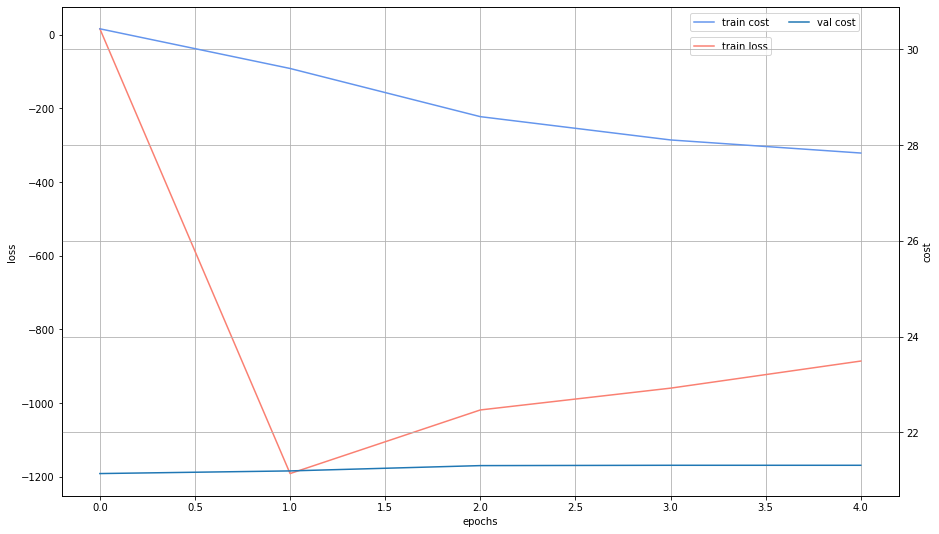

In [15]:
import tensorflow as tf
from time import gmtime, strftime

#from attention_dynamic_model import AttentionDynamicModel, set_decode_type
# from reinforce_baseline import RolloutBaseline
# from train import train_model

# from utils import create_data_on_disk, get_cur_time

# Params of model
SAMPLES = 512 # 128*10000
BATCH = 128
START_EPOCH = 0
END_EPOCH = 5
FROM_CHECKPOINT = False
embedding_dim = 128
LEARNING_RATE = 0.0001
ROLLOUT_SAMPLES = 10000
NUMBER_OF_WP_EPOCHS = 1
GRAD_NORM_CLIPPING = 1.0
BATCH_VERBOSE = 1000
VAL_BATCH_SIZE = 1000
VALIDATE_SET_SIZE = 10000
SEED = 1234
GRAPH_SIZE = 50
FILENAME = 'VRP_{}_{}'.format(GRAPH_SIZE, strftime("%Y-%m-%d", gmtime()))

# Initialize model
model_tf = AttentionDynamicModel(embedding_dim)
set_decode_type(model_tf, "sampling")
print(get_cur_time(), 'model initialized')

# Create and save validation dataset
validation_dataset = create_data_on_disk(GRAPH_SIZE,
                                         VALIDATE_SET_SIZE,
                                         is_save=True,
                                         filename=FILENAME,
                                         is_return=True,
                                         seed = SEED)
print(get_cur_time(), 'validation dataset created and saved on the disk')

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# Initialize baseline
baseline = RolloutBaseline(model_tf,
                           wp_n_epochs = NUMBER_OF_WP_EPOCHS,
                           epoch = 0,
                           num_samples=ROLLOUT_SAMPLES,
                           filename = FILENAME,
                           from_checkpoint = FROM_CHECKPOINT,
                           embedding_dim=embedding_dim,
                           graph_size=GRAPH_SIZE
                           )
print(get_cur_time(), 'baseline initialized')

train_model(optimizer,
            model_tf,
            baseline,
            validation_dataset,
            samples = SAMPLES,
            batch = BATCH,
            val_batch_size = VAL_BATCH_SIZE,
            start_epoch = START_EPOCH,
            end_epoch = END_EPOCH,
            from_checkpoint = FROM_CHECKPOINT,
            grad_norm_clipping = GRAD_NORM_CLIPPING,
            batch_verbose = BATCH_VERBOSE,
            graph_size = GRAPH_SIZE,
            filename = FILENAME
            )